In [2]:
%load_ext autoreload
%autoreload 2
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset
from hmpai.data import SAT1_STAGES_ACCURACY, COMMON_STAGES, SAT_CLASSES_ACCURACY
from hmpai.visualization import plot_confusion_matrix, plot_predictions_on_epoch
from hmpai.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS
from torch.utils.data import DataLoader
from mne.io import read_info
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
DATA_PATH = Path(os.getenv("DATA_PATH"))

Train model on SAT2 Dataset

In [3]:
set_global_seed(42)
data_path_sat2 = DATA_PATH / "sat2/stage_data_proba_100hz.nc"
dataset_sat2 = xr.load_dataset(data_path_sat2)
# data_path_sat1 = DATA_PATH / "sat1/stage_data_100hz.nc"
# dataset_sat1 = xr.load_dataset(data_path_sat1)
# dataset_sat1 = dataset_sat1.rename_vars({'RT': 'rt'})

In [4]:
shape_topological = False
info_to_keep = ['rt']
train_data_sat2, val_data_sat2, test_data_sat2 = split_data_on_participants(
    dataset_sat2, 60, norm_min1_to_1
)
# train_data_sat1, val_data_sat1, test_data_sat1 = split_data_on_participants(
#     dataset_sat1, 60, norm_min1_to_1
# )
test_dataset_sat2 = SAT1Dataset(test_data_sat2, shape_topological=shape_topological, labels=SAT_CLASSES_ACCURACY, set_to_zero=True)
# test_dataset_sat1 = SAT1Dataset(test_data_sat1, shape_topological=shape_topological, labels=SAT_CLASSES_ACCURACY, set_to_zero=True)
test_loader_sat2 = DataLoader(
    test_dataset_sat2, batch_size=128, shuffle=True, num_workers=0, pin_memory=True
)
# test_loader_sat1 = DataLoader(
#     test_dataset_sat1, batch_size=128, shuffle=True, num_workers=0, pin_memory=True
# )

In [5]:
chk_path = Path("../models/sat2_proba.pt")
checkpoint = load_model(chk_path)

# model = Seq2SeqTransformer(d_model=30, ff_dim=2048, num_heads=8, num_layers=10, num_classes=len(SAT_CLASSES_ACCURACY), emb_dim=64)
# model = Seq2SeqTransformer(d_model=30, ff_dim=512, num_heads=8, num_layers=6, num_classes=len(SAT_CLASSES_ACCURACY), emb_dim=255)
# model = Seq2SeqTransformer(d_model=30, ff_dim=2048, num_heads=8, num_layers=6, num_classes=len(SAT_CLASSES_ACCURACY), emb_dim=1024)

# model_kwargs = {
#     "d_model": len(train_data_sat2.channels),
#     "num_heads": 2,
#     "ff_dim": 256,
#     "num_layers": 1,
#     "num_classes": len(SAT_CLASSES_ACCURACY),
#     "emb_dim": 64,
# }
model_kwargs = {
    "d_model": len(train_data_sat2.channels),
    "num_heads": 8,
    "ff_dim": 2048,
    "num_layers": 6,
    "num_classes": len(SAT_CLASSES_ACCURACY),
    "emb_dim": 1024,
}
model = Seq2SeqTransformer(**model_kwargs)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)
model.set_pretraining(False)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
#SAT1
window_size = 11
amount_of_graphs = 10
counter = 0
for batch in test_loader_sat1:
    for epoch, true in zip(batch[0], batch[1]):
        print(true)
        # Change function to support whole sequence
        plot_predictions_on_epoch(epoch, true, SAT_CLASSES_ACCURACY, window_size, model, smoothing=False, sequence=True)
        counter += 1
        if counter >= amount_of_graphs: break
    break

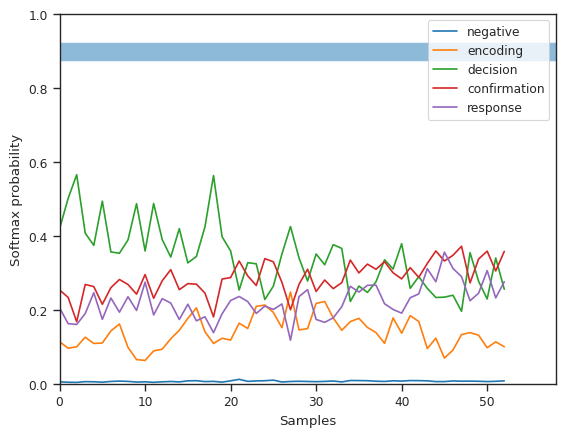

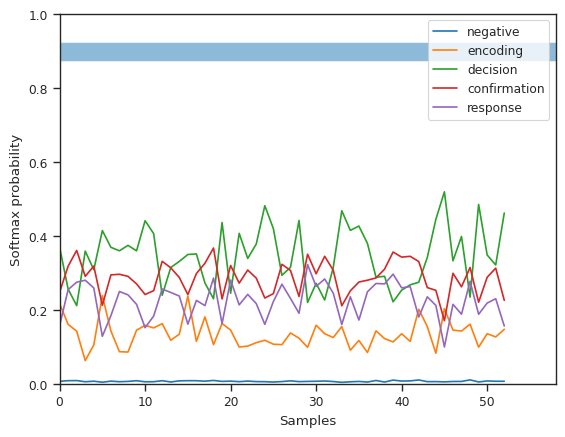

----------


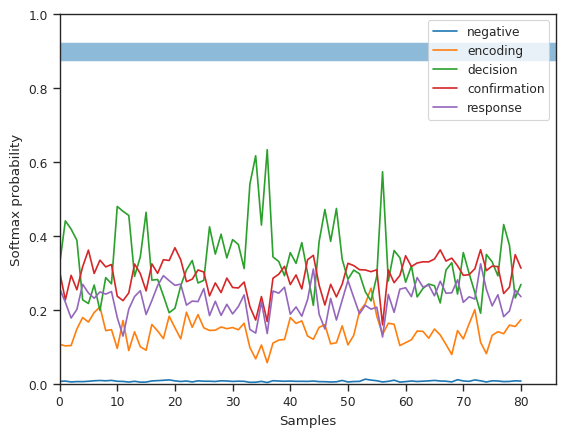

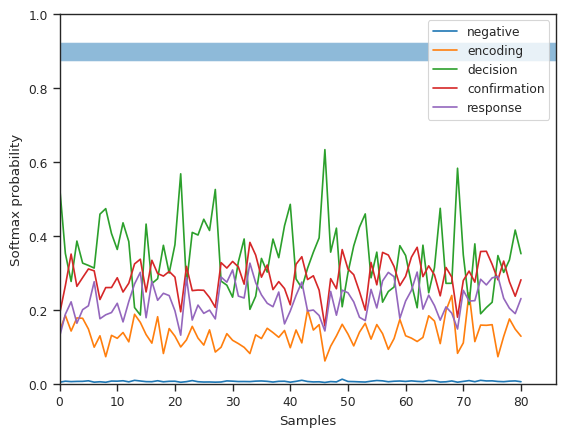

----------


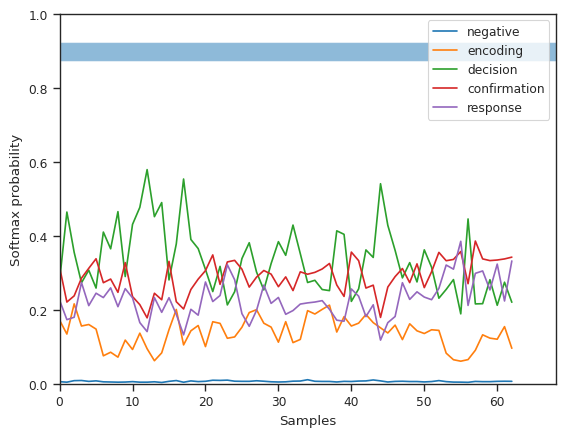

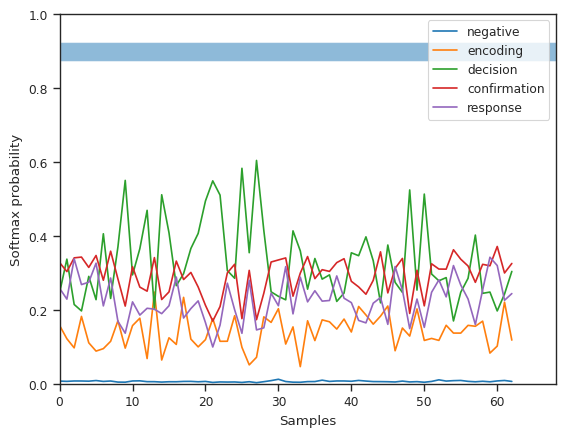

----------


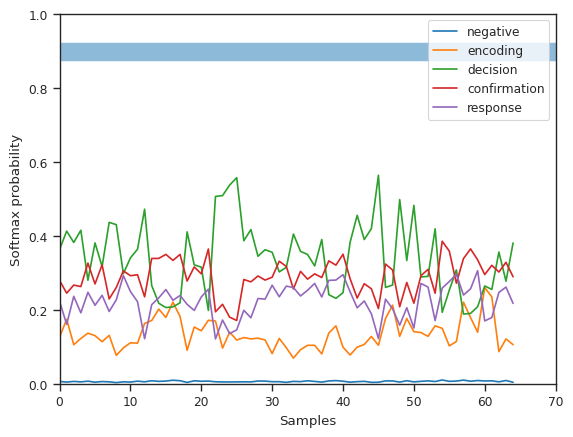

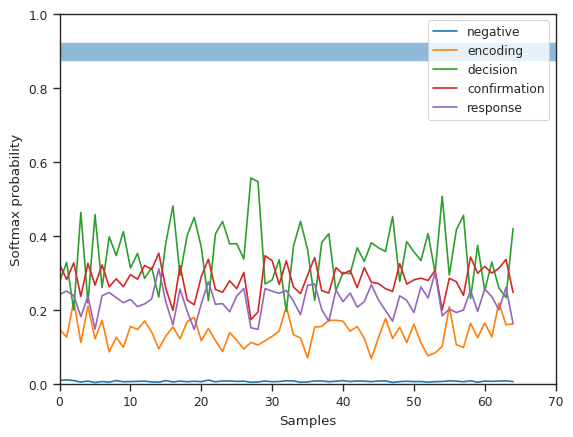

----------


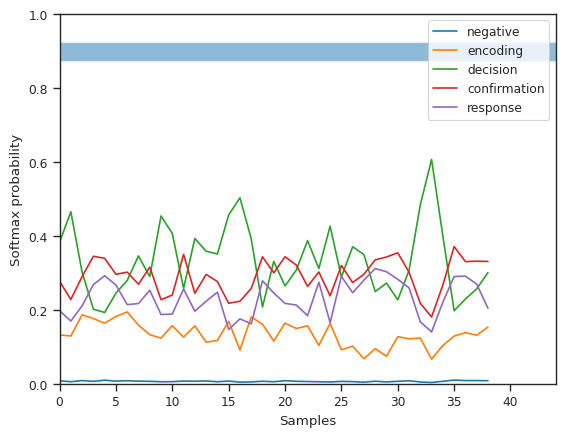

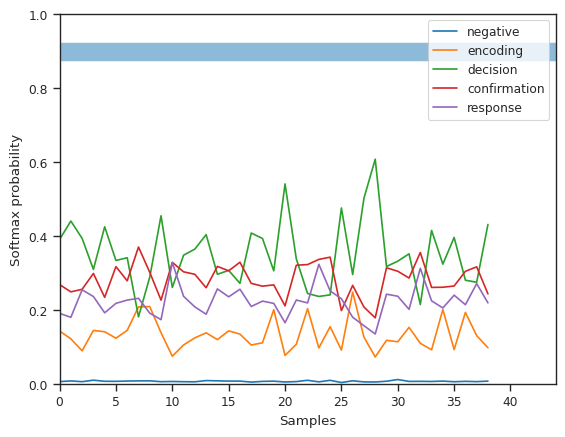

----------


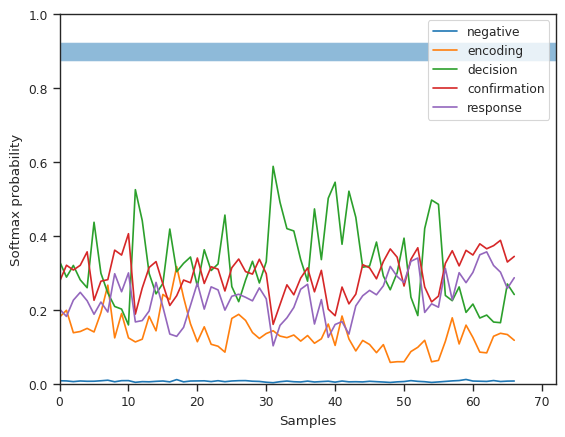

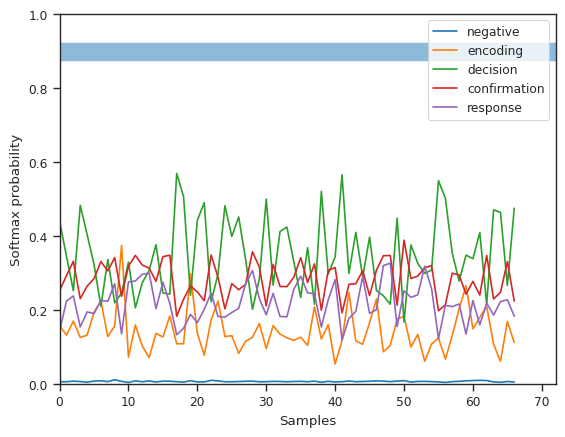

----------


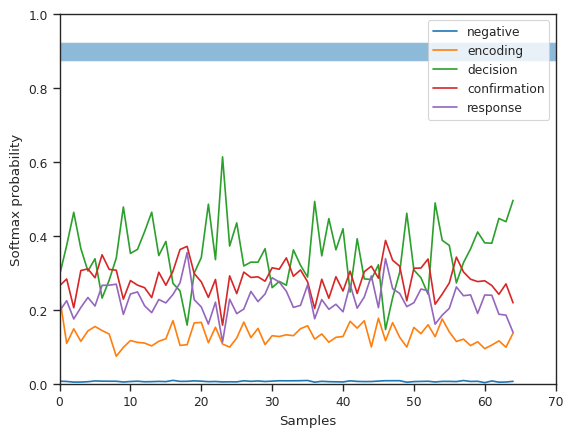

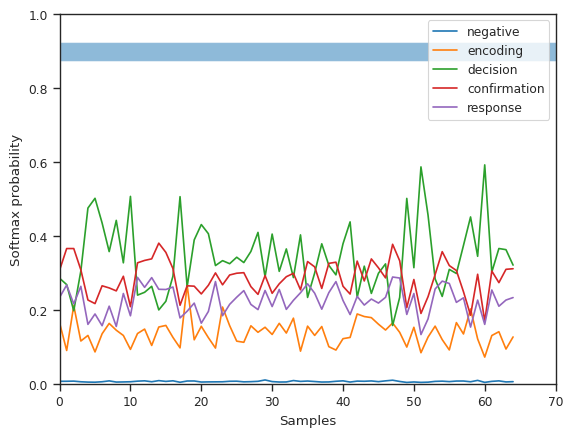

----------


KeyboardInterrupt: 

In [7]:
# SAT2
window_size = 11
amount_of_graphs = 10
counter = 0
for batch in test_loader_sat2:
    for epoch, true in zip(batch[0], batch[1]):
        # Change function to support whole sequence
        plot_predictions_on_epoch(
            epoch,
            true,
            SAT_CLASSES_ACCURACY,
            window_size,
            model,
            smoothing=False,
            sequence=True,
            random_perm=False,
        )
        plot_predictions_on_epoch(
            epoch,
            true,
            SAT_CLASSES_ACCURACY,
            window_size,
            model,
            smoothing=False,
            sequence=True,
            random_perm=True,
        )
        print("----------")
        counter += 1
        if counter >= amount_of_graphs:
            break
    break

tensor([2, 4, 1, 2, 4, 2, 0, 2, 0, 1, 2, 2, 1, 2, 1, 2, 4, 2, 2, 4, 2, 1, 2, 2,
        1, 2, 1, 2, 2, 4, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 4, 1, 2, 1, 2, 2, 2, 2,
        2, 2, 4, 4, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


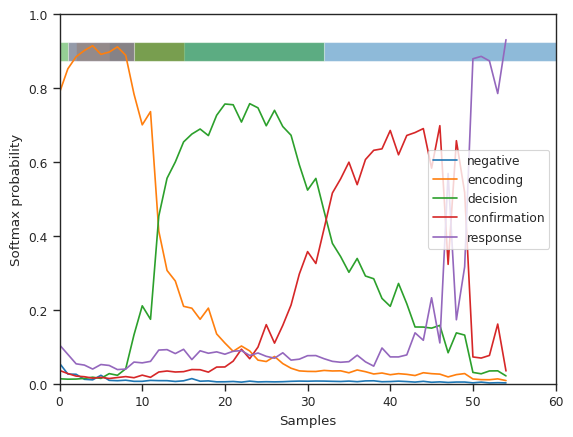

tensor([2, 3, 3, 4, 3, 2, 4, 2, 1, 1, 3, 2, 2, 1, 0, 1, 2, 4, 1, 3, 3, 1, 3, 0,
        2, 2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 2, 3, 1, 4, 3, 3, 3, 2, 1, 2, 4, 3,
        2, 1, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


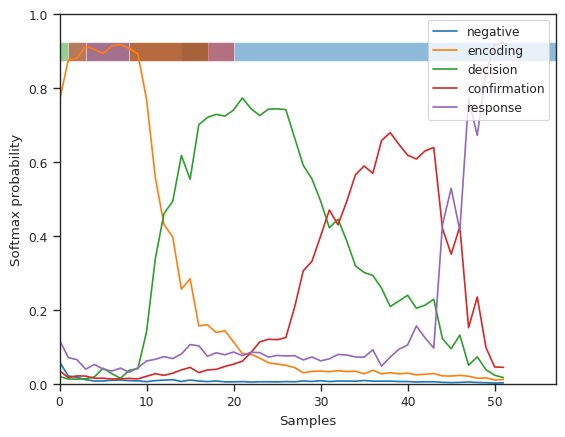

tensor([2, 2, 2, 2, 4, 4, 2, 1, 4, 4, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2,
        2, 2, 2, 1, 2, 2, 2, 4, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


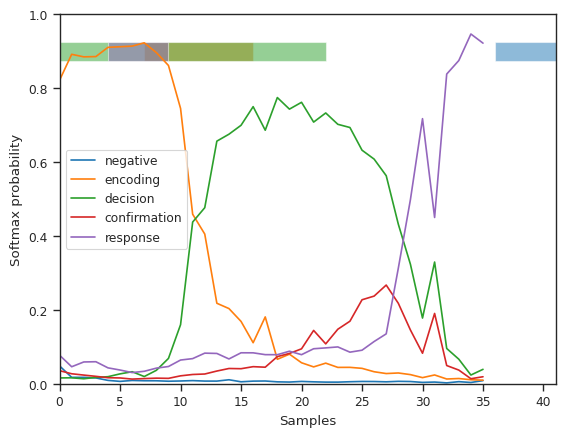

tensor([2, 2, 4, 1, 2, 2, 2, 0, 2, 2, 4, 1, 1, 2, 0, 2, 2, 2, 2, 0, 2, 1, 1, 2,
        2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 4, 2, 1,
        2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 0, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1,
        1, 2, 0, 2, 2, 2, 2, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


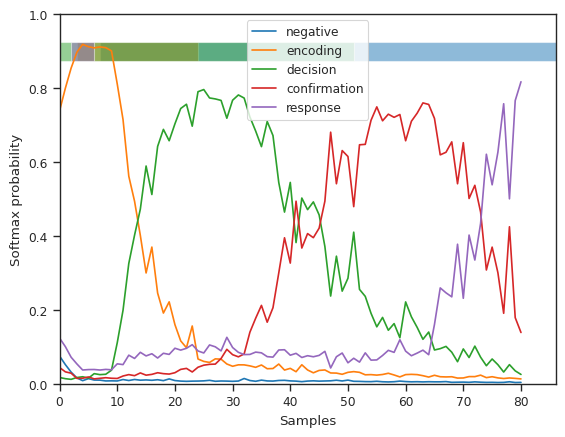

tensor([2, 2, 1, 1, 2, 4, 1, 1, 2, 2, 2, 3, 1, 1, 2, 3, 3, 1, 3, 2, 3, 3, 3, 3,
        3, 2, 3, 3, 1, 1, 3, 2, 3, 2, 4, 3, 2, 2, 2, 4, 3, 1, 3, 1, 1, 2, 3, 0,
        3, 1, 0, 2, 1, 4, 3, 1, 1, 3, 4, 2, 2, 1, 2, 1, 2, 0, 2, 2, 2, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


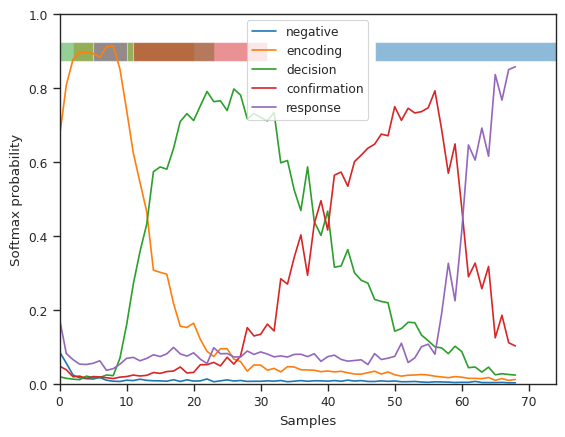

tensor([3, 1, 3, 2, 4, 3, 2, 2, 1, 3, 3, 3, 2, 3, 3, 1, 2, 1, 2, 1, 4, 2, 4, 2,
        3, 2, 2, 1, 3, 3, 2, 3, 2, 3, 2, 2, 3, 2, 2, 3, 3, 4, 2, 1, 3, 0, 3, 2,
        3, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 3, 2, 1, 3, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


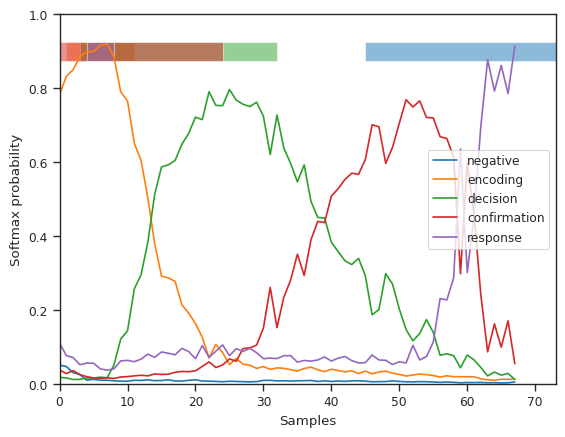

tensor([1, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 4, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2,
        2, 2, 1, 2, 4, 2, 2, 2, 2, 4, 1, 2, 2, 2, 2, 2, 2, 4, 2, 1, 2, 2, 1, 2,
        2, 1, 4, 2, 2, 2, 4, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


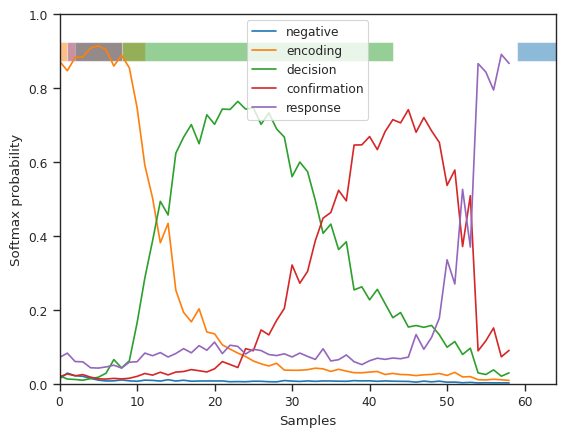

tensor([4, 3, 2, 2, 3, 1, 2, 2, 1, 2, 4, 0, 1, 2, 2, 3, 2, 2, 3, 2, 3, 4, 2, 2,
        1, 2, 3, 2, 2, 3, 1, 3, 2, 3, 1, 3, 1, 3, 3, 3, 4, 2, 1, 1, 3, 3, 1, 3,
        3, 2, 3, 2, 3, 1, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 3, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


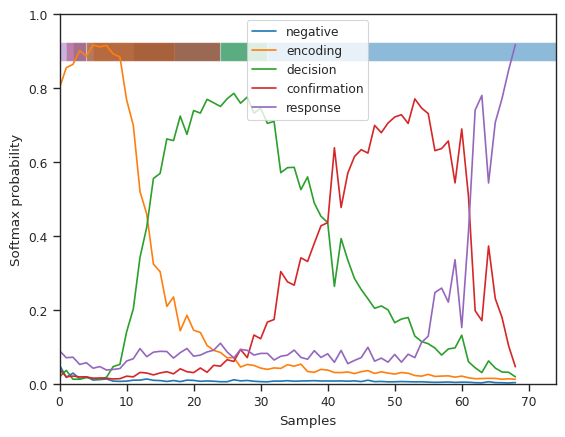

tensor([3, 4, 2, 2, 2, 2, 1, 3, 3, 0, 2, 3, 1, 3, 1, 1, 2, 2, 3, 3, 2, 3, 2, 4,
        3, 2, 3, 3, 2, 2, 3, 3, 2, 3, 2, 2, 3, 4, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 2, 2, 1, 3, 3, 2, 2, 2, 3, 2, 1, 2, 3, 2, 3, 4, 2, 2, 2, 3, 1,
        3, 3, 1, 3, 3, 2, 2, 3, 3, 3, 3, 3, 1, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


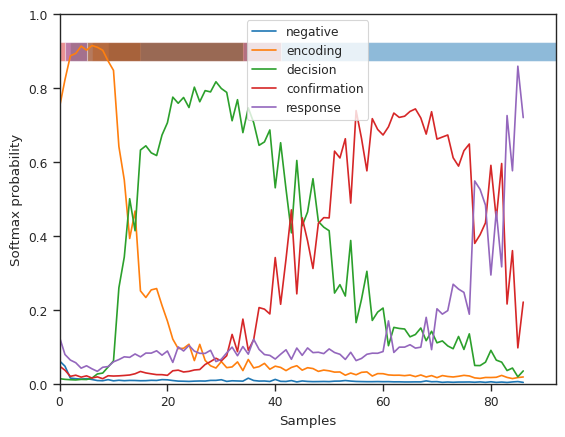

tensor([1, 2, 1, 3, 2, 3, 2, 4, 4, 2, 2, 2, 1, 0, 3, 2, 2, 3, 2, 2, 2, 4, 2, 2,
        2, 2, 2, 3, 3, 4, 2, 3, 0, 3, 2, 3, 3, 2, 3, 3, 3, 2, 0, 3, 3, 2, 2, 2,
        2, 3, 3, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


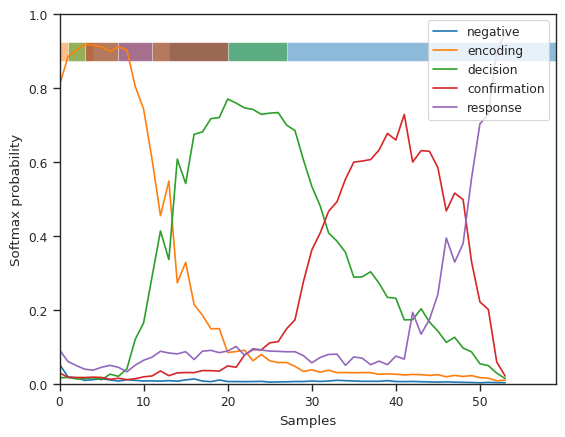

In [8]:
# SAT2
window_size = 11
amount_of_graphs = 10
counter = 0
for batch in test_loader_sat2:
    for epoch, true in zip(batch[0], batch[1]):
        # Change function to support whole sequence
        plot_predictions_on_epoch(
            epoch,
            true,
            SAT_CLASSES_ACCURACY,
            window_size,
            model,
            smoothing=False,
            sequence=True,
            random_perm=True,
        )
        counter += 1
        if counter >= amount_of_graphs:
            break
    break